## Credit Risk Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV


In [2]:
df = pd.read_csv(r"german_credit_data.csv")
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [3]:
df = df.drop(df.columns[0],axis = 1)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
df.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

In [5]:
df.isna().any()

Age                 False
Sex                 False
Job                 False
Housing             False
Saving accounts      True
Checking account     True
Credit amount       False
Duration            False
Purpose             False
Risk                False
dtype: bool

In [6]:
null_count_saving = df['Saving accounts'].isnull().sum()
null_count_checking = df['Checking account'].isnull().sum()

print(f"The 'Saving accounts' column has {null_count_saving} null values.")
print(f"The 'Checking account' column has {null_count_checking} null values.")

The 'Saving accounts' column has 183 null values.
The 'Checking account' column has 394 null values.


In [7]:
df['Saving accounts'].fillna('Unknown', inplace=True)
df['Checking account'].fillna('Unknown', inplace = True)

print(df['Saving accounts'].value_counts())
print(df['Checking account'].value_counts())

little        603
Unknown       183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64
Unknown     394
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64


In [8]:
df.isna().any()

Age                 False
Sex                 False
Job                 False
Housing             False
Saving accounts     False
Checking account    False
Credit amount       False
Duration            False
Purpose             False
Risk                False
dtype: bool

In [9]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


In [11]:
df['Risk'].value_counts()

good    700
bad     300
Name: Risk, dtype: int64

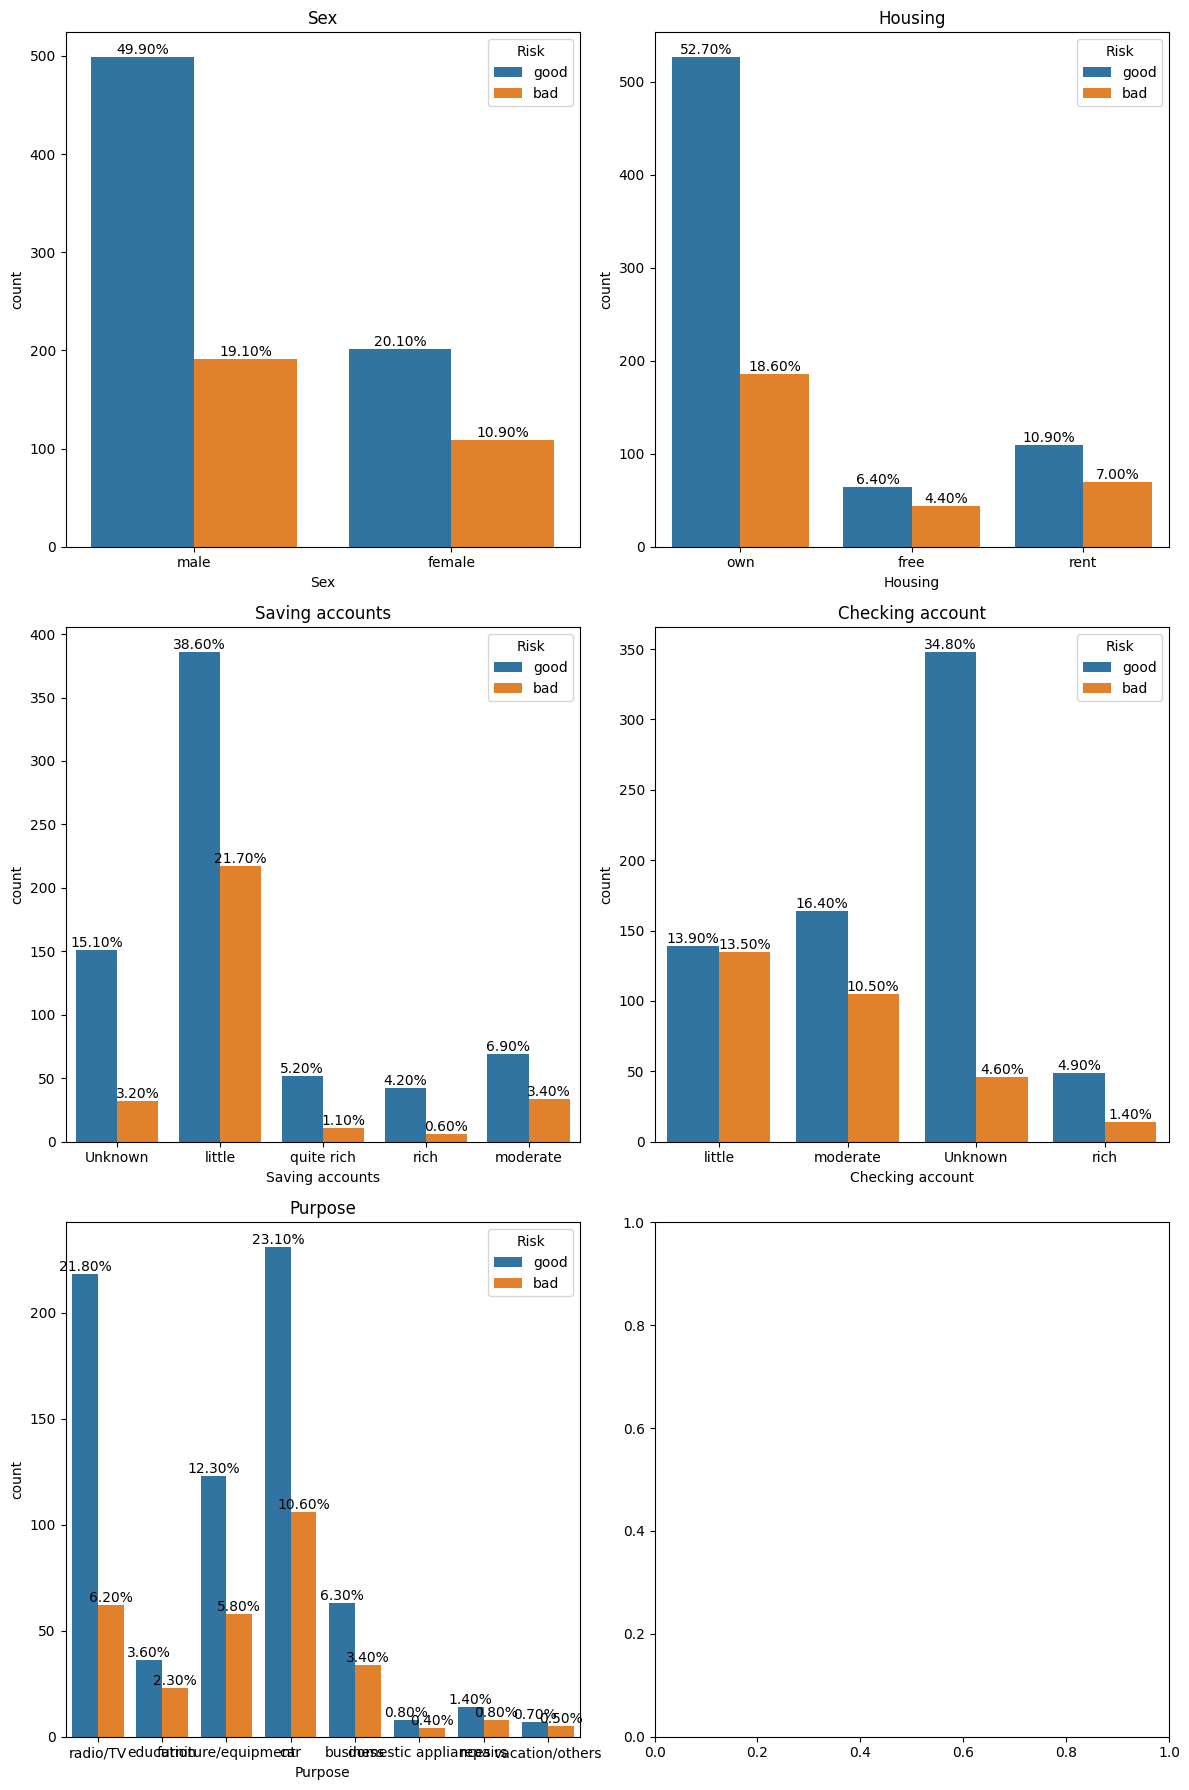

In [12]:
# Define the list of categorical columns
categorical_columns = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

# Calculate the number of rows and columns for the subplot grid
num_plots = len(categorical_columns)
num_rows = (num_plots + 1) // 2  # Round up to the nearest integer
num_cols = min(num_plots, 2)

# Calculate the figure size based on the number of columns
fig_width = 6 * num_cols
fig_height = 6 * num_rows

# Create the subplot grid with increased size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

# Iterate over each categorical column and create a countplot in the corresponding subplot
for i, column in enumerate(categorical_columns):
    row = i // num_cols
    col = i % num_cols

    if num_rows == 1:
        ax = axes[col]
    else:
        ax = axes[row, col]

    sns.countplot(x=column, hue='Risk', data=df, ax=ax)

    ax.set_title(column)

    total = len(df[column])  # Total number of data points

    for p in ax.patches:
        height = p.get_height()
        percentage = height / total * 100
        ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom')

# Adjust the spacing between subplots
plt.tight_layout()

plt.show()

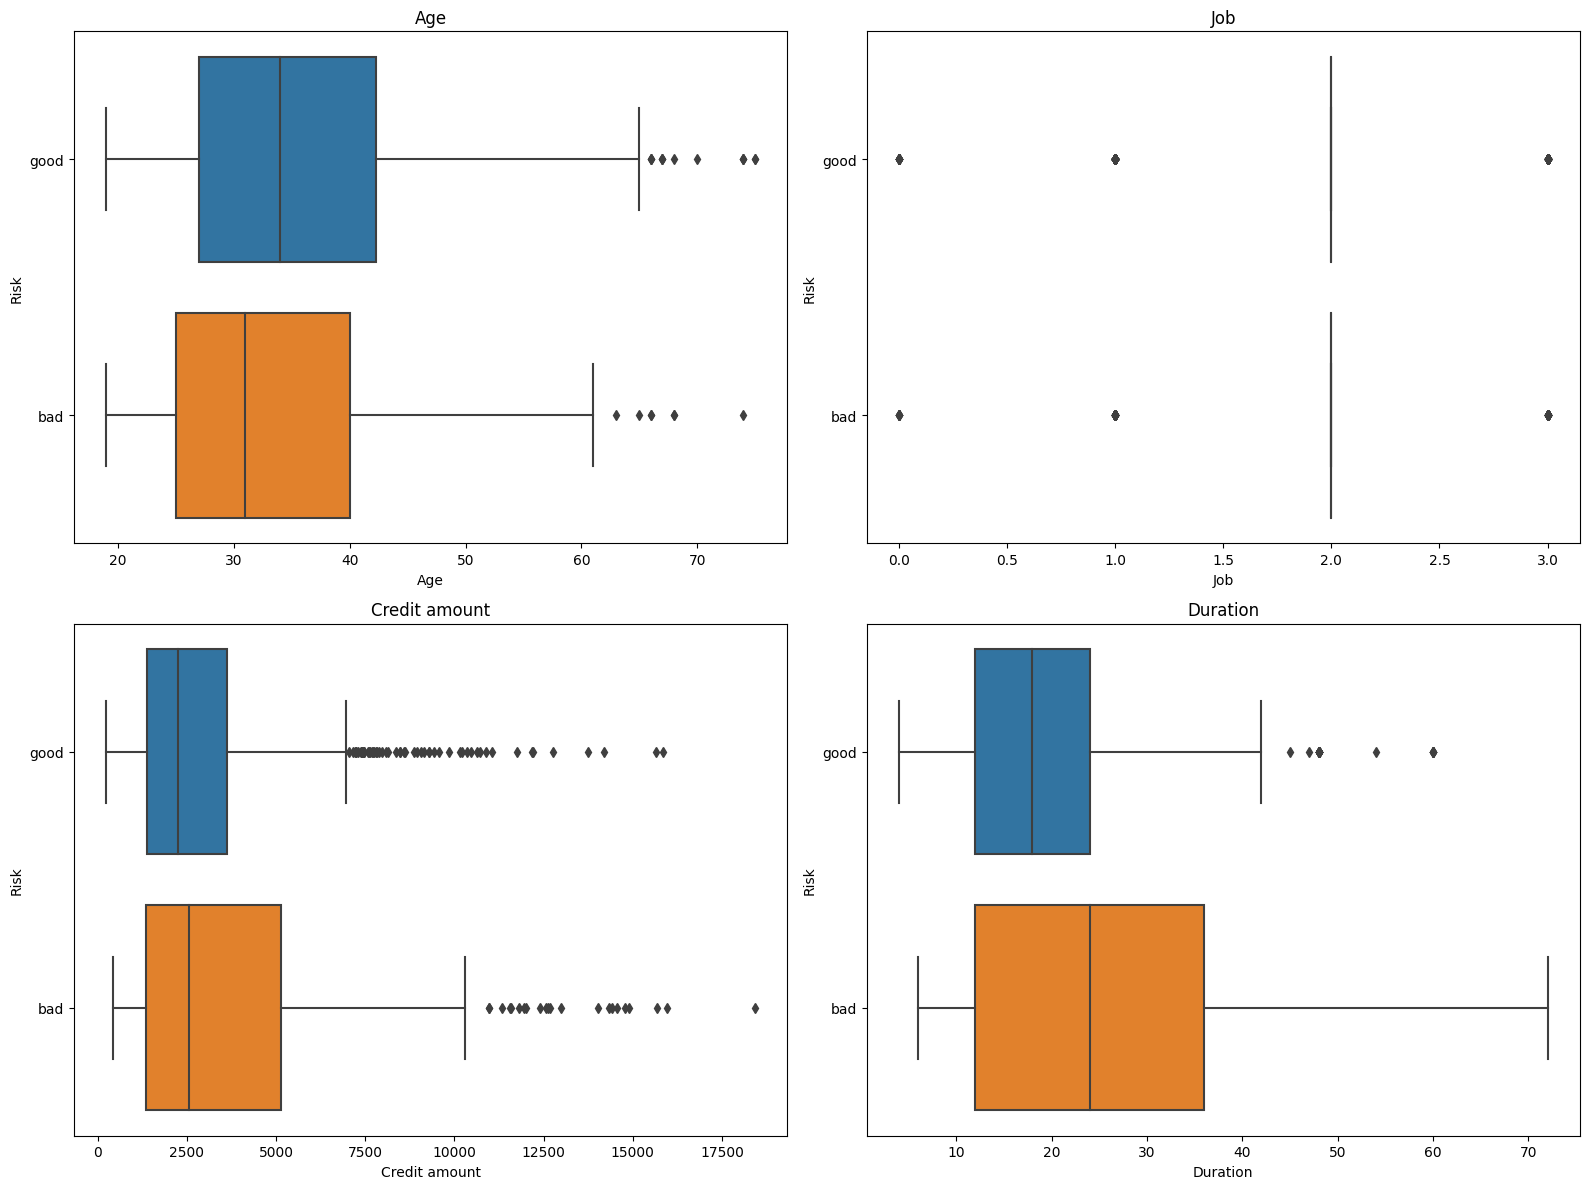

In [13]:
# Define the list of numerical columns
numerical_columns = ['Age', 'Job', 'Credit amount', 'Duration']

# Calculate the number of rows and columns for the subplot grid
num_plots = len(numerical_columns)
num_rows = (num_plots + 1) // 2  # Round up to the nearest integer
num_cols = min(num_plots, 2)

# Calculate the figure size based on the number of columns
fig_width = 8 * num_cols
fig_height = 6 * num_rows

# Create the subplot grid with increased size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

# Iterate over each numerical column and create a boxplot in the corresponding subplot
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols

    if num_rows == 1:
        ax = axes[col]
    else:
        ax = axes[row, col]

    sns.boxplot(x=column, y='Risk', data=df, ax=ax)

    ax.set_title(column)

# Adjust the spacing between subplots
plt.tight_layout()

plt.show()

In [14]:
df['Job'].value_counts()

2    630
1    200
3    148
0     22
Name: Job, dtype: int64

In [15]:
le = LabelEncoder()
le_count = 0
for col in df.columns:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            le.fit(df[col])
            df[col] = le.transform(df[col])
            le_count += 1
print('{} columns were label encoded'.format(le_count))


2 columns were label encoded


In [16]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,own,Unknown,little,1169,6,radio/TV,1
1,22,0,2,own,little,moderate,5951,48,radio/TV,0
2,49,1,1,own,little,Unknown,2096,12,education,1
3,45,1,2,free,little,little,7882,42,furniture/equipment,1
4,53,1,2,free,little,little,4870,24,car,0


In [17]:
# Select the categorical columns for one-hot encoding
categorical_columns = ['Housing', 'Saving accounts', 'Checking account', 'Purpose']

# Perform one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns)

# Print the encoded dataframe
print(df_encoded.head())

   Age  Sex  Job  Credit amount  Duration  Risk  Housing_free  Housing_own  \
0   67    1    2           1169         6     1             0            1   
1   22    0    2           5951        48     0             0            1   
2   49    1    1           2096        12     1             0            1   
3   45    1    2           7882        42     1             1            0   
4   53    1    2           4870        24     0             1            0   

   Housing_rent  Saving accounts_Unknown  ...  Checking account_moderate  \
0             0                        1  ...                          0   
1             0                        0  ...                          1   
2             0                        0  ...                          0   
3             0                        0  ...                          0   
4             0                        0  ...                          0   

   Checking account_rich  Purpose_business  Purpose_car  \
0              

In [18]:
df_encoded.columns

Index(['Age', 'Sex', 'Job', 'Credit amount', 'Duration', 'Risk',
       'Housing_free', 'Housing_own', 'Housing_rent',
       'Saving accounts_Unknown', 'Saving accounts_little',
       'Saving accounts_moderate', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Checking account_Unknown',
       'Checking account_little', 'Checking account_moderate',
       'Checking account_rich', 'Purpose_business', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others'],
      dtype='object')

In [19]:
df2 = df_encoded[['Age', 'Sex', 'Job', 'Credit amount', 'Duration',
       'Housing_free', 'Housing_own', 'Housing_rent',
       'Saving accounts_Unknown', 'Saving accounts_little',
       'Saving accounts_moderate', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Checking account_Unknown',
       'Checking account_little', 'Checking account_moderate',
       'Checking account_rich', 'Purpose_business', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others']] 

correlations = df2.corrwith(df_encoded['Risk'])
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations>0].sort_values(ascending=False)
negative_correlations = correlations[correlations<0].sort_values(ascending=False)
print('Most Positive Correlations: \n', positive_correlations)
print('Most Negative Correlations: \n', negative_correlations)



Most Positive Correlations: 
 Checking account_Unknown      0.322436
Housing_own                   0.134589
Saving accounts_Unknown       0.129238
Purpose_radio/TV              0.106922
Age                           0.091127
Saving accounts_rich          0.085749
Sex                           0.075493
Saving accounts_quite rich    0.070954
Checking account_rich         0.044009
dtype: float64
Most Negative Correlations: 
 Purpose_domestic appliances   -0.008016
Purpose_repairs               -0.020828
Purpose_furniture/equipment   -0.020971
Saving accounts_moderate      -0.022255
Purpose_car                   -0.022621
Purpose_vacation/others       -0.028058
Job                           -0.032735
Purpose_business              -0.036129
Purpose_education             -0.049085
Housing_free                  -0.081556
Housing_rent                  -0.092785
Checking account_moderate     -0.119581
Credit amount                 -0.154739
Saving accounts_little        -0.161007
Duration      

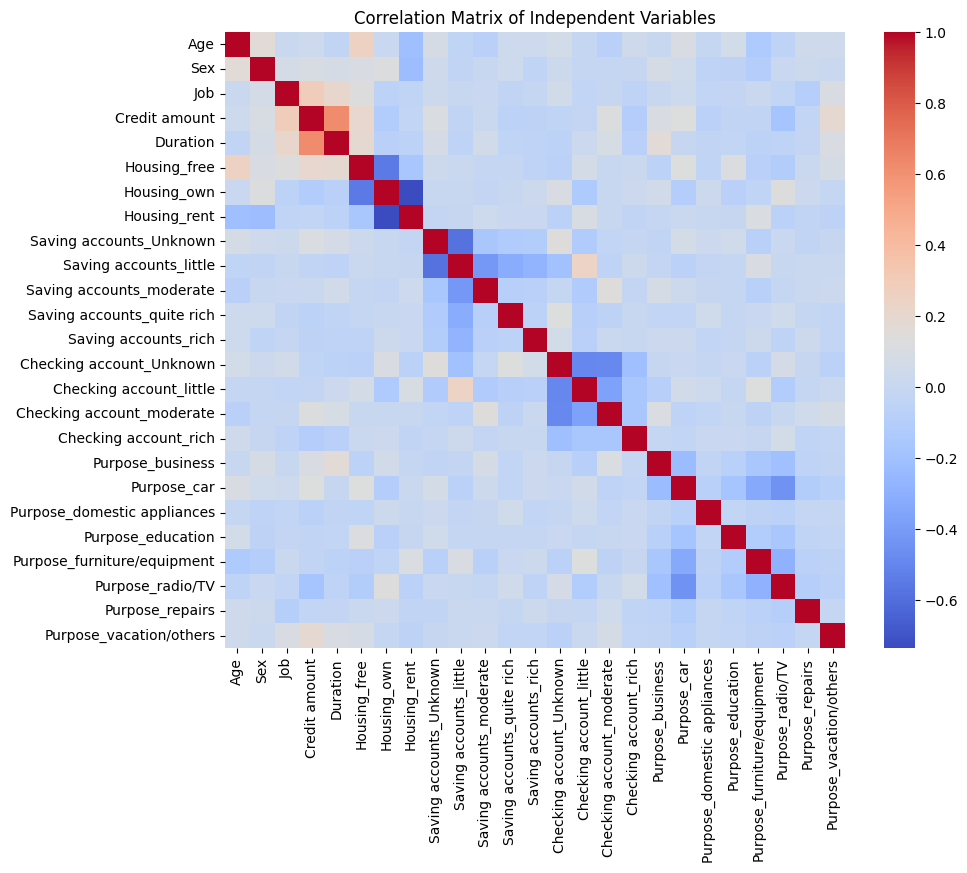

In [20]:
# Select the independent variables for correlation analysis
# Compute the correlation matrix
correlation_matrix = df2.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')

# Set plot title
plt.title("Correlation Matrix of Independent Variables")

# Display the heatmap
plt.show()


In [21]:
# Add a constant column for the intercept term
df2= sm.add_constant(df2)

# Calculate VIF for each independent variable
vif = pd.DataFrame()
vif['Variable'] = df2.columns
vif['VIF'] = [sm.OLS(df2[col], df2.drop(columns=[col])).fit().rsquared for col in df2.columns]

# Print the VIF values
print(vif)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                       Variable       VIF
0                         const      -inf
1                           Age  0.145500
2                           Sex  0.091346
3                           Job  0.108983
4                 Credit amount  0.471350
5                      Duration  0.429669
6                  Housing_free  1.000000
7                   Housing_own  1.000000
8                  Housing_rent  1.000000
9       Saving accounts_Unknown  1.000000
10       Saving accounts_little  1.000000
11     Saving accounts_moderate  1.000000
12   Saving accounts_quite rich  1.000000
13         Saving accounts_rich  1.000000
14     Checking account_Unknown  1.000000
15      Checking account_little  1.000000
16    Checking account_moderate  1.000000
17        Checking account_rich  1.000000
18             Purpose_business  1.000000
19                  Purpose_car  1.000000
20  Purpose_domestic appliances  1.000000
21            Purpose_education  1.000000
22  Purpose_furniture/equipment  1

In [22]:
# Select the independent variables and the target variable
X = df_encoded[['Age', 'Sex', 'Job', 'Credit amount', 'Duration',
                'Housing_free', 'Housing_own', 'Housing_rent',
                'Saving accounts_Unknown', 'Saving accounts_little',
                'Saving accounts_moderate', 'Saving accounts_quite rich',
                'Saving accounts_rich', 'Checking account_Unknown',
                'Checking account_little', 'Checking account_moderate',
                'Checking account_rich', 'Purpose_business', 'Purpose_car',
                'Purpose_domestic appliances', 'Purpose_education',
                'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
                'Purpose_vacation/others']]
y = df_encoded['Risk']

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (800, 25) (800,)
Testing set shape: (200, 25) (200,)


In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
# Logistic Regression
logreg = LogisticRegression(max_iter = 1000)
logreg.fit(X_train, y_train)
logreg_predictions = logreg.predict(X_test)

# Calculate evaluation metrics for Logistic Regression
logreg_accuracy = accuracy_score(y_test, logreg_predictions)
logreg_precision = precision_score(y_test, logreg_predictions)
logreg_recall = recall_score(y_test, logreg_predictions)
logreg_f1 = f1_score(y_test, logreg_predictions)

print("Logistic Regression:")
print("Accuracy:", logreg_accuracy)
print("Precision:", logreg_precision)
print("Recall:", logreg_recall)
print("F1 Score:", logreg_f1)

Logistic Regression:
Accuracy: 0.75
Precision: 0.7757575757575758
Recall: 0.9078014184397163
F1 Score: 0.8366013071895424


In [25]:
# XGBoost
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)
xgb_predictions = xgb_classifier.predict(X_test)

# Calculate evaluation metrics for XGBoost
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_precision = precision_score(y_test, xgb_predictions)
xgb_recall = recall_score(y_test, xgb_predictions)
xgb_f1 = f1_score(y_test, xgb_predictions)

print("\nXGBoost:")
print("Accuracy:", xgb_accuracy)
print("Precision:", xgb_precision)
print("Recall:", xgb_recall)
print("F1 Score:", xgb_f1)


XGBoost:
Accuracy: 0.75
Precision: 0.7898089171974523
Recall: 0.8794326241134752
F1 Score: 0.8322147651006712


In [26]:
# Define the parameter grids for each model
logistic_regression_params = {
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'lbfgs']
}

logistic_regression_grid = GridSearchCV(logreg, logistic_regression_params, cv=5)
logistic_regression_grid.fit(X_train, y_train)

best_logistic_regression = logistic_regression_grid.best_estimator_

y_pred_lr = best_logistic_regression.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("Logistic Regression:")
print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1 Score:", f1_lr)

Logistic Regression:
Accuracy: 0.76
Precision: 0.7852760736196319
Recall: 0.9078014184397163
F1 Score: 0.8421052631578948


In [27]:
xgboost_params = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

xgboost_grid = GridSearchCV(xgb_classifier, xgboost_params, cv=5)
xgboost_grid.fit(X_train, y_train)

best_xgboost = xgboost_grid.best_estimator_

y_pred_xgb = best_xgboost.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print("\nXGBoost:")
print("Accuracy:", accuracy_xgb)
print("Precision:", precision_xgb)
print("Recall:", recall_xgb)
print("F1 Score:", f1_xgb)



XGBoost:
Accuracy: 0.78
Precision: 0.8050314465408805
Recall: 0.9078014184397163
F1 Score: 0.8533333333333334
